# Predicting Dog Breed from Images - Model Training
## By: Cullan Bedwell, Frank Vasquez, Lauren Bassett, Maggie Houck

This notebook is for training the final models for predicting dog breeds based on images. The images are sourced from The Stanford Dogs dataset, which has 120 different dog breeds with ~150 images per class of purebred dogs.

This notebook trains two models:
*   Normal Model
*   Cut Mix Model

These models leverage weights from MobileNetV2 as a starting point before adding some additional layers for training. The Normal Model trains only using the given training images while the Cut Mix Model uses the Cut Mix Method to overlay images on top of one another and uses a custom training implementation.

We hope that both methods prove to predict the given data well, and we hope to extrapolate the results to mixed breed dogs, especially with the implementation of the Cut Mix Method.

Resources:
*   Stanford Dogs Dataset: http://vision.stanford.edu/aditya86/ImageNetDogs/
*   Cut Mix Repository: https://github.com/jis478/Tensorflow/tree/master/TF2.0/

## Set-Up

### Imports

In [ ]:
## Directory Packges ##
import os
from glob import glob
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

## Data Packages ##
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
from tqdm import tqdm

## Tensorflow ##
import tensorflow as tf
from tensorflow import keras

Mounted at /content/drive


### Constants

In [ ]:
## Image Parameters ##
size = 224
num_classes = 120

## Model Parameters ##
lr = 1e-4
batch = 36
epochs = 10

## CutMix Parameters ##
beta = 0.75
cutmix_prob = 0.5

## Pathings ##
PATH = "drive/My Drive/dog-breed-identification/"
train_path = os.path.join(PATH, "train/*")
test_path = os.path.join(PATH, "test/*")
labels_path = os.path.join(PATH, "labels.csv")
models_path = PATH + 'models/'

### Functions

In [ ]:
## Load Data Functions##

# Match Image ID to Dog Breed Label
def get_labels(ids, labels_df, breed2id):
  
  labels = []
  for image_id in ids:
      image_id = image_id.split("/")[-1].split(".")[0]
      breed_name = list(labels_df[labels_df.id == image_id]["breed"])[0]
      breed_idx = breed2id[breed_name]
      labels.append(breed_idx)

  return labels

# Load Image from File Path 
def read_image(path, size):

    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (size, size))
    image = image / 255.0
    image = image.astype(np.float32)

    return image

# Parse for Image + One Hot Encoded Labels
def tf_parse(x, y):

    def parse_data(x, y):

        x = x.decode()

        image = read_image(x, size)
        label = [0] * num_classes
        label[y] = 1
        label = np.array(label)
        label = label.astype(np.int32)

        return image, label

    x, y = tf.numpy_function(parse_data, [x, y], [tf.float32, tf.int32])
    x.set_shape((224, 224, 3))
    y.set_shape((120))

    return x, y

# Create Tensorflow Dataset from Images + Labels
def tf_dataset(x, y, batch=8):
  
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()

    return dataset

In [ ]:
## Model Functions ##

# Build Model for Training
def build_model(size, num_classes):

    # Define Input Images
    inputs = keras.layers.Input((size, size, 3))

    # Using MobileNetV2 as Backbone of The Model
    backbone = keras.applications.MobileNetV2(
        input_tensor=inputs, include_top=False, weights="imagenet"
    )
    backbone.trainable = True
    
    # Adding Some Addition Layers
    x = backbone.output
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(1024, activation="relu")(x)
    x = keras.layers.Dense(num_classes, activation="softmax")(x)

    # Combine for Final Model
    model = keras.Model(inputs, x)

    return model


# Random Bounding Box for Cut Mix Images
def rand_bbox(size, lam):

    W = size[1] 
    H = size[2]
    
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int32(W * cut_rat)
    cut_h = np.int32(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)
    
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

## Load Data

### Labels

In [ ]:
# Load Lables
labels_df = pd.read_csv(labels_path)

# Create Lookup for Breed Name + ID
breed = labels_df["breed"].unique()
breed2id = {name: i for i, name in enumerate(breed)}
id2breed = {i: name for i, name in enumerate(breed)}

### Training + Validation Data

In [ ]:
# Load Image IDs
train_ids = glob(train_path)

# Get Lables
train_labels = get_labels(train_ids, labels_df, breed2id)

# Split the Data into Training + Validtion
train_x, valid_x = train_test_split(train_ids, test_size=0.2, random_state=42)
train_y, valid_y = train_test_split(train_labels, test_size=0.2, random_state=42)

# Fully Load Data in TF Dataset
train_dataset = tf_dataset(train_x, train_y, batch=batch)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch)

## Example Images

### Normal Images

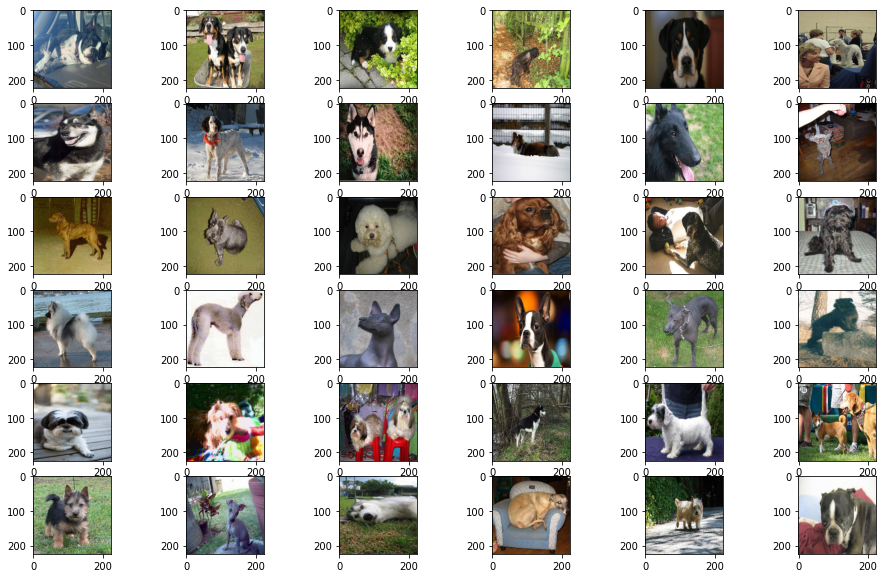

In [ ]:
# Show the First Batch of Images
plt.figure(figsize=(16, 10))

for image, target in train_dataset:
    for i in range(batch):
      plt.subplot(6, 6, i+1)
      plt.imshow(image[i])
      
    break
 
plt.show()

### Cut Mix Images

In [ ]:
# Create Cut Mix Images on First Batch
# Hardcoded Certain Values for Demonstration
for image, target in train_dataset:       
    lam = np.random.beta(beta, beta)
    rand_index = tf.random.shuffle(tf.range(len(target)))
    target_a = target
    target_b = tf.gather(target, rand_index)
    bbx1, bby1, bbx2, bby2 = rand_bbox(image.shape, .85)
    image_a = image
    image_b = tf.gather(image, rand_index)
    mask = np.ones_like(image)
    mask[:, bbx1:bbx2, bby1:bby2, :] = 0          
    image_cutmix = tf.math.multiply(image_a,mask) + tf.math.multiply(image_b, (abs(1.-mask)))
    
    break

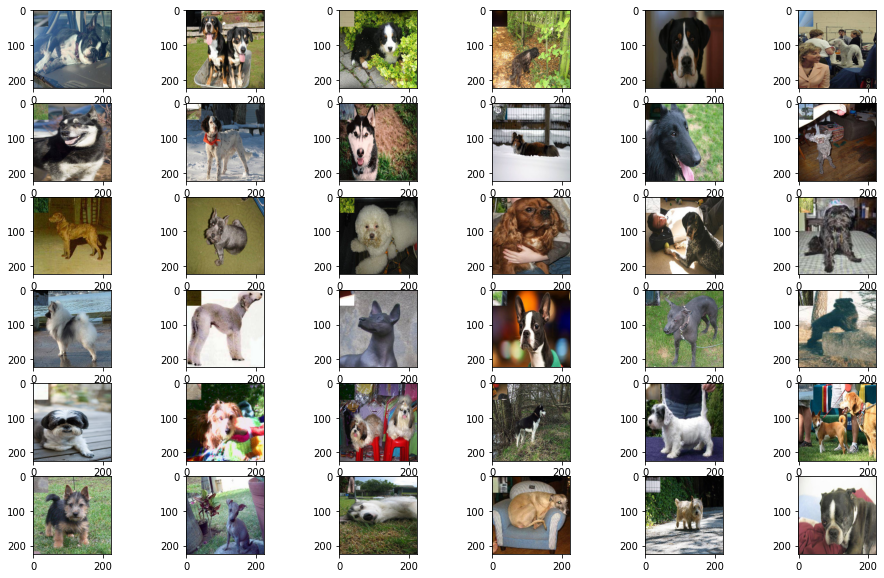

In [ ]:
# Show the First Batch of Cut Mix Images
plt.figure(figsize=(16, 10))

for i in range(batch):
  plt.subplot(6, 6, i+1)
  plt.imshow(image_cutmix[i])
 
plt.show()

## Model Training

In [ ]:
# Number of Steps for Training + Validation
train_steps = (len(train_x) // batch) + 1 
valid_steps = (len(valid_x) // batch) + 1

### Normal Model

In [ ]:
# Set-Up Callback
callbacks = [
    keras.callbacks.ModelCheckpoint(
        models_path + "model_normal.h5", verbose=1, save_best_only=True),
    keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-6)
]

# Build Model
model_norm = build_model(size, num_classes)
model_norm.compile(
    loss="categorical_crossentropy", 
    optimizer=keras.optimizers.Adam(lr), 
    metrics=["acc"]
)
# model_norm.summary()

# Train Model
model_norm.fit(
    train_dataset,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    validation_data=valid_dataset,
    epochs=epochs,
    callbacks=callbacks
)

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/10
228/228 [==============================] - ETA: 0s - loss: 2.6465 - acc: 0.4109
Epoch 1: val_loss improved from inf to 1.38448, saving model to drive/My Drive/dog-breed-identification/models/model_normal.h5
228/228 [==============================] - 235s 978ms/step - loss: 2.6465 - acc: 0.4109 - val_loss: 1.3845 - val_acc: 0.5927 - lr: 1.0000e-04
Epoch 2/10
227/228 [============================>.] - ETA: 0s - loss: 0.7481 - acc: 0.7955
Epoch 2: val_loss improved from 1.38448 to 1.16905, saving model to drive/My Drive/dog-breed-identification/models/model_normal.h5
228/228 [==============================] - 80s 350ms/step - loss: 0.7477 - acc: 0.7956 - val_loss: 1.1690 - val_acc: 0.6450 - lr: 1.0000e-04
Epoch 3/10
227/228 [============================>.] - ETA: 0s - loss: 0.2780 - acc: 0.9408
Epoch 3: val_loss improved from 1.16905 to 1.07001, saving model to drive/My Drive/dog-breed-identification/models/model_no

### CutMix Model

In [ ]:
## Model HyperParameters + Metrics ##

# Loss + Optimizer
criterion = tf.keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.Adam(lr)

# Training Metrics
train_loss = keras.metrics.Mean(name='train_loss')
train_acc_top1 = keras.metrics.TopKCategoricalAccuracy(k=1, name='train_acc_top1')
train_acc_top3 = keras.metrics.TopKCategoricalAccuracy(k=3, name='train_acc_top3')
train_acc_top5 = keras.metrics.TopKCategoricalAccuracy(k=5, name='train_acc_top5')

# Validation Metrics
valid_loss = keras.metrics.Mean(name='valid_loss')
valid_acc_top1 = keras.metrics.TopKCategoricalAccuracy(k=1, name='valid_acc_top1')
valid_acc_top3 = keras.metrics.TopKCategoricalAccuracy(k=3, name='valid_acc_top3')
valid_acc_top5 = keras.metrics.TopKCategoricalAccuracy(k=5, name='valid_acc_top5')

# Template for Printing Progress
progress_template = '''
******* 
  Epoch: {:3d} / {:3d}, Time: {:.3f}, Time / Step: {:.3f}
  Train Loss: {:.4f}, Train Top 1 Acc: {:.4f}, Train Top 3 Acc: {:.4f}, Train Top 5 Acc: {:.4f}
  Valid Loss: {:.4f}, Valid Top 1 Acc: {:.4f}, Valid Top 3 Acc: {:.4f}, Valid Top 5 Acc: {:.4f}
*******
'''

In [ ]:
## TensorFlow Functions for Training Model ##

# Train on CutMix Image
@tf.function
def train_cutmix_image(image_cutmix, target_a, target_b, lam):

  with tf.GradientTape() as tape:
      output = model(image_cutmix, training=True) 
      loss = criterion(target_a, output) * lam + \
              criterion(target_b, output) * (1. - lam)

  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables)) 

  return loss, output

# Train on Normal Image
@tf.function
def train_original_image(image, target):

  with tf.GradientTape() as tape:
      output = model(image, training=True)
      loss = criterion(target, output)

  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables)) 

  return loss, output

In [ ]:
## Model Training ##

# Build Model
model = build_model(size, num_classes)

# Custom Training
for epoch in range(epochs):

  # Record Time
  start = time.time()

  # Reset Training Metrics
  train_loss.reset_states()
  train_acc_top1.reset_states()
  train_acc_top3.reset_states()
  train_acc_top5.reset_states()

  # Reset Validation Metrics
  valid_loss.reset_states()
  valid_acc_top1.reset_states()
  valid_acc_top3.reset_states()
  valid_acc_top5.reset_states()

  # Reset Step Counts for Training + Validation
  cnt_train = 0
  cnt_valid = 0
  
  # Iterate Through Batch
  for image, target in train_dataset: 
    
    # Random Probability Between Using CutMix or Normal Images
    r = np.random.rand(1)
      
    # Train on Cut Mix Image
    if beta > 0 and r < cutmix_prob:

        # Generate CutMix Images
        lam = np.random.beta(beta, beta)
        rand_index = tf.random.shuffle(tf.range(len(target)))
        target_a = target
        target_b = tf.gather(target, rand_index)
        bbx1, bby1, bbx2, bby2 = rand_bbox(image.shape, lam)       
        image_a = image
        image_b = tf.gather(image, rand_index)
        mask = np.ones_like(image)
        mask[:, bbx1:bbx2, bby1:bby2, :] = 0            

        image_cutmix = tf.math.multiply(image_a, mask) + \
                        tf.math.multiply(image_b, abs(1.0 - mask))
        
        lam = tf.convert_to_tensor(
          1 - ((bbx2 - bbx1) * (bby2 - bby1) / 
                (image_cutmix.shape[1] * image_cutmix.shape[2])
          ), dtype=tf.float32
        )

        # Train on the Modified Images
        loss, output = train_cutmix_image(image_cutmix, target_a, target_b, lam)      
        
    # Train on Original Image
    else:
        loss, output = train_original_image(image, target)

    # Look at Training Metrics
    train_loss(loss)
    train_acc_top1(target, output)
    train_acc_top3(target, output)
    train_acc_top5(target, output)

    # Keep Track of Number of Training Steps
    cnt_train += 1

    # Manual Stop to End Epoch + Print Progress
    if cnt_train == train_steps: 
        break
    elif cnt_train % 50 == 0:
        print('.', end='')

  # Look at Validation Predictions
  for image, target in valid_dataset:
    
    # Predict 
    output = model(image, training=False)
    loss = criterion(target, output)

    # Look at Validation Metrics
    valid_loss(loss)
    valid_acc_top1(target, output)
    valid_acc_top3(target, output)
    valid_acc_top5(target, output)

    # Keep Track of Number of Validation Steps
    cnt_valid +=1 

    # Manual Stop to End Validation Check
    if cnt_valid == valid_steps: 
        break
    elif cnt_valid % 50 == 0:
        print('.', end='')

  total_time = time.time()-start

  # Print Metrics At End of Epoch
  print(
    progress_template.format(
      epoch+1, epochs, total_time, total_time/train_steps,
      train_loss.result(), train_acc_top1.result(), train_acc_top3.result(), train_acc_top5.result(),
      valid_loss.result(), valid_acc_top1.result(), valid_acc_top3.result(), valid_acc_top5.result(),
    )
  )

# Save Model
model.save_weights(models_path + "model_cutmix.h5")

.....
******* 
  Epoch:   1 /  10, Time: 89.567, Time / Step: 0.393
  Train Loss: 3.2303, Train Top 1 Acc: 0.2996, Train Top 3 Acc: 0.4674, Train Top 5 Acc: 0.5379
  Valid Loss: 1.4105, Valid Top 1 Acc: 0.6161, Valid Top 3 Acc: 0.8533, Valid Top 5 Acc: 0.9154
*******

.....
******* 
  Epoch:   2 /  10, Time: 102.376, Time / Step: 0.449
  Train Loss: 1.8676, Train Top 1 Acc: 0.5796, Train Top 3 Acc: 0.7461, Train Top 5 Acc: 0.7922
  Valid Loss: 1.2133, Valid Top 1 Acc: 0.6689, Valid Top 3 Acc: 0.8773, Valid Top 5 Acc: 0.9315
*******

.....
******* 
  Epoch:   3 /  10, Time: 102.379, Time / Step: 0.449
  Train Loss: 1.5291, Train Top 1 Acc: 0.6725, Train Top 3 Acc: 0.7953, Train Top 5 Acc: 0.8272
  Valid Loss: 1.2577, Valid Top 1 Acc: 0.6538, Valid Top 3 Acc: 0.8758, Valid Top 5 Acc: 0.9301
*******

.....
******* 
  Epoch:   4 /  10, Time: 102.378, Time / Step: 0.449
  Train Loss: 1.3588, Train Top 1 Acc: 0.6993, Train Top 3 Acc: 0.7791, Train Top 5 Acc: 0.8038
  Valid Loss: 1.1631, Vali

## Summary

Normal Model Results:
*   Training Accuracy - 0.9998
*   Testing Accuracy - 0.7663

Cut Mix Model Results:
*   Training Accuracy - 0.7640
*   Testing Accuracy - 0.6797

The Cut Mix Model overall appears to be less accurate than running the model normally. However, it also is much less overfit than the normal model. Additionally, the results on the validation set are not too terribly different, especially factoring in more than only the top result since it's top 3 validation accuracy is 0.8709 and top 5 validation accuracy is 0.9222. With these reults, we hope that with this new method of training, it will work better on mixed breed dogs than the original model since the training only has purebred images.
